<img SRC="https://avatars2.githubusercontent.com/u/31697400?s=400&u=a5a6fc31ec93c07853dd53835936fd90c44f7483&v=4" WIDTH=125 ALIGN="right">
    
# Surface water example
   
*D.A. Brakenhoff, Artesia, 2020*

This example notebook shows some how to add surface water defined in a shapefile to a MODFLOW model using the `nlmod` package.
    
    
## Contents<a id='top'></a>

1. [Load data](#1)
2. [Build model](#2)
3. [Add surface water](#3)
    1. [Intersect surface water shape with grid](#3.1)
    2. [Aggregate parameters per model cell](#3.2)
    3. [Build stress period data](#3.3)
    4. [Create RIV package](#3.4)
4. [Write + run model](#4)
5. [Visualize results](#5)

### TODO:

- Transient boundary conditions (i.e. functionality to use strings for parameters and write timeseries)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import flopy

import nlmod

In [2]:
print(f'nlmod version: {nlmod.__version__}')

nlmod version: 0.0.2b


## [Load data](#top)<a id='1'></a>
Load shapefile with surface water features. 

In [3]:
sfw = gpd.read_file("../data/shapes/schnhvn_opp_water.shp")
# vervang peilvak_id met None door 'None'
sfw.loc[sfw.peilvak_id.isna(), 'peilvak_id'] = 'None'

Take a look at the first few rows. For adding surface water features to a MODFLOW model the following attributes must be present:

- **stage**: the water level (in m NAP)
- **botm**: the bottom elevation (in m NAP)
- **c0**: the bottom resistance (in days)

The `stage` and the `botm` columns are present in our dataset. The bottom resistance `c0` is rarely known, and is usually estimated when building the model. We will add our estimate later on.

*__Note__: the NaN's in the dataset indicate that not all parameters are known for each feature. This is not necessarily a problem but this will mean some features will not be converted to model input.*

Plot the surface water features using the column `peilvak_id` to color the features. 

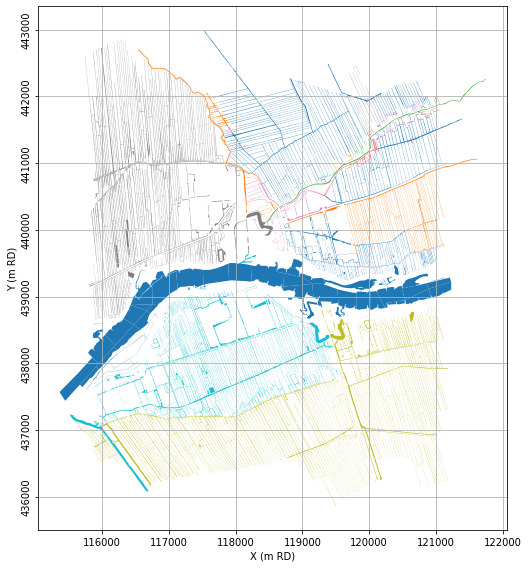

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.set_aspect("equal", adjustable="box")
sfw.plot(ax=ax, column="peilvak_id")
ax.grid(b=True)
ax.set_xlabel("X (m RD)")
ax.set_ylabel("Y (m RD)")
plt.yticks(rotation=90, va="center")
fig.tight_layout()

Now use `stage` as the column to color the data. Note the missing features caused by the fact that the stage is undefined (NaN).

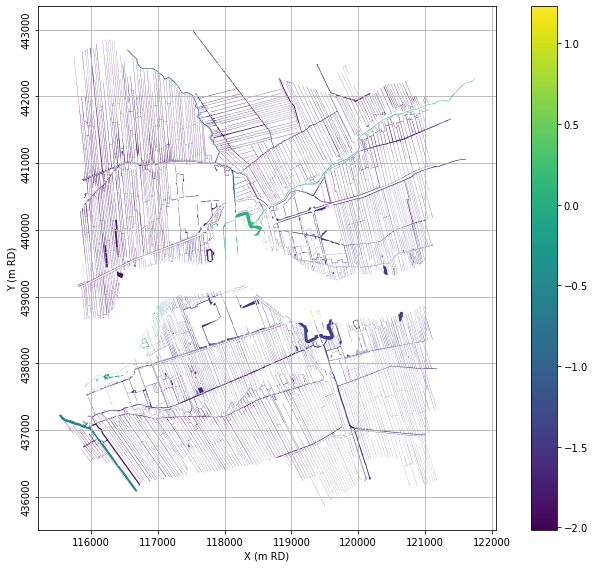

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.set_aspect("equal", adjustable="box")
sfw.plot(ax=ax, column="stage", legend=True)
ax.grid(b=True)
ax.set_xlabel("X (m RD)")
ax.set_ylabel("Y (m RD)")
plt.yticks(rotation=90, va="center")
fig.tight_layout()

## [Build model](#top)<a id='2'></a>

The next step is to define a model grid and build a model (i.e. create a discretization and define flow parameters). First we define the extent of our model and subsequently input that information into the convenient methods in `nlmod` to download all the relevant data and create a Modflow6 model. 

In [6]:
extent = [115900, 121000, 436600, 442000]  # Schoonhoven

Build the model. We're keeping the model as simple as possible.

In [7]:
verbose = True
use_cache = True
model_name = "model3"
model_ws = "./model3"

delr = delc = 50.0
start_time = "2021-01-01"

In [8]:
# Model directories
figdir, cachedir = nlmod.util.get_model_dirs(model_ws)

# create model time dataset
model_ds = nlmod.mdims.get_model_ds_time(model_name, model_ws,
                                         start_time=start_time,
                                         steady_state=True)

extent, nrow, ncol = nlmod.read.regis.fit_extent_to_regis(extent, delr, delc,
                                                          verbose=verbose)

# layer model
layer_model = nlmod.read.regis.get_layer_models(extent,
                                                delr, delc,
                                                use_regis=True,
                                                use_geotop=False,
                                                cachedir="./model3/cache",
                                                fname_netcdf='combined_layer_ds.nc',
                                                use_cache=use_cache,
                                                verbose=verbose)

# create modflow packages
sim, gwf = nlmod.mfpackages.sim_tdis_gwf_ims_from_model_ds(model_ds,
                                                           verbose=verbose)

redefining current extent: [115900, 121000, 436600, 442000], fit to regis raster
new extent is [115900, 121000.0, 436600, 442000.0] model has 108 rows and 102 columns
found cached combined_layer_ds.nc, loading cached dataset
delr of current grid is the same as cached grid
delc of current grid is the same as cached grid
extent of current grid is the same as cached grid
creating modflow SIM, TDIS, GWF and IMS


In [9]:
# update model_ds from layer model
model_ds = nlmod.mdims.update_model_ds_from_ml_layer_ds(model_ds,
                                                        layer_model,
                                                        keep_vars=['x', 'y'],
                                                        add_northsea=False,
                                                        use_cache=use_cache,
                                                        verbose=verbose)

# Create discretization
dis = nlmod.mfpackages.dis_from_model_ds(model_ds, gwf)

# create node property flow
npf = nlmod.mfpackages.npf_from_model_ds(model_ds, gwf)

# Create the initial conditions package
ic = nlmod.mfpackages.ic_from_model_ds(model_ds, gwf, starting_head=1.0)

# Create the output control package
oc = nlmod.mfpackages.oc_from_model_ds(model_ds, gwf)

add kh and kv from model layer dataset to modflow model
kv and kh both undefined in layer 0
layer 1 has a kh
layer 2 has a kh
layer 3 has a kh
layer 4 has a kv
layer 5 has a kh
layer 6 has a kh
layer 7 has a kh
layer 8 has a kh
layer 9 has a kh
layer 10 has a kh
layer 11 has a kh
layer 12 has a kv
layer 13 has a kh
layer 14 has a kv
layer 15 has a kh
layer 16 has a kh
layer 17 has a kv
layer 18 has a kh
layer 19 has a kv
layer 20 has a kh
layer 21 has a kv
layer 22 has a kh
layer 23 has a kh
layer 24 has a kv
layer 25 has a kh
layer 26 has a kv
layer 27 has a kh
layer 28 has a kh
layer 29 has a kh
layer 30 has a kv
layer 31 has a kh
layer 32 has a kh
layer 33 has a kh
layer 34 has a kv
kv and kh both undefined in layer 0
layer 1 has a kh
layer 2 has a kh
layer 3 has a kh
layer 4 has a kv
layer 5 has a kh
layer 6 has a kh
layer 7 has a kh
layer 8 has a kh
layer 9 has a kh
layer 10 has a kh
layer 11 has a kh
layer 12 has a kv
layer 13 has a kh
layer 14 has a kv
layer 15 has a kh
layer 16

## [Add surface water](#top)<a id='3'></a>

Now that we have a discretization (a grid, and layer tops and bottoms) we can start processing our surface water shapefile to add surface water features to our model. The method to add surface water starting from a shapefile is divided into the following steps:

1. Intersect surface water shape with grid. This steps intersects every feature with the grid so we can determine the surface water features in each cell.
2. Aggregate parameters per grid cell. Each feature within a cell has its own parameters. For MODFLOW it is often desirable to have one representative set of parameters per cell. These representative parameters are calculated in this step.
3. Build stress period data. The results from the previous step are converted to stress period data (generally a list of cellids and representative parameters: `[(cellid), parameters]`) which is used by MODFLOW and flopy to define boundary conditions.
4. Create the Modflow6 package

The steps are illustrated below.

### [Intersect surface water shape with grid](#top)<a id='3.1'></a>

The first step is to intersect the surface water shapefile with the grid.

In [10]:
sfw_grid = nlmod.mfpackages.surface_water.gdf2grid(sfw, gwf)

Intersecting with grid: 100%|██████████| 3883/3883 [00:21<00:00, 179.13it/s]


Plot the result and the model grid and color using `cellid`. It's perhaps a bit hard to see but each feature is cut by the gridlines. 

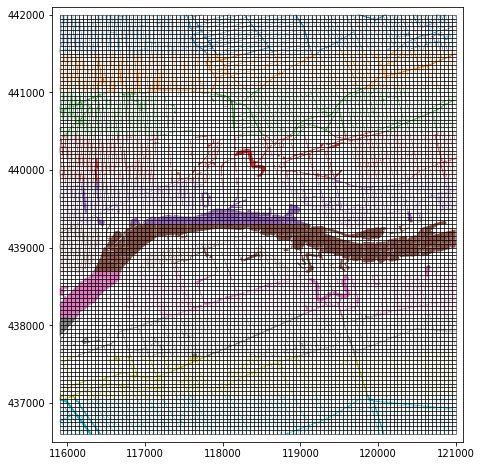

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.set_aspect("equal", adjustable="box")
sfw_grid.plot(ax=ax, column="cellid")
gwf.modelgrid.plot(ax=ax, linewidth=0.5, color="k")
xmin, xmax, ymin, ymax = extent
offset = 100
ax.set_xlim(xmin-offset, xmax+offset)
ax.set_ylim(ymin-offset, ymax+offset);

### [Aggregate parameters per model cell](#top)<a id='3.2'></a>

The next step is to aggregate the parameters for all the features in one grid cell to obtain one representative set of parameters. First, let's take a look at a grid cell containing multiple features.

In [12]:
cid = (107, 6)  # for 50 x 50 m grid
# cid = (5, 45)  # for 100 x 100 m grid
mask = sfw_grid.cellid == cid
sfw_grid.loc[mask]

,unique_id,peilvak_id,zp,wp,stage,botm,geometry,cellid
25,NL.9.324708,NL.9.OVW200,-0.63,-0.63,-0.630,-2.12,"POLYGON ((116250.000 436643.360, 116247.320 43...","(107, 6)"
328,NL.9.239597,NL.9.NDW036,-1.99,-2.04,-2.015,-2.34,"POLYGON ((116250.000 436619.371, 116249.120 43...","(107, 6)"
329,NL.9.239597,NL.9.NDW036,-1.99,-2.04,-2.015,-2.34,"POLYGON ((116231.080 436648.080, 116230.760 43...","(107, 6)"
333,NL.9.289792,NL.9.NDW036,-1.99,-2.04,-2.015,-2.34,"POLYGON ((116200.682 436629.617, 116200.000 43...","(107, 6)"
334,NL.9.289792,NL.9.NDW036,-1.99,-2.04,-2.015,-2.34,"POLYGON ((116202.937 436620.942, 116200.000 43...","(107, 6)"


We can also plot the features within that grid cell.

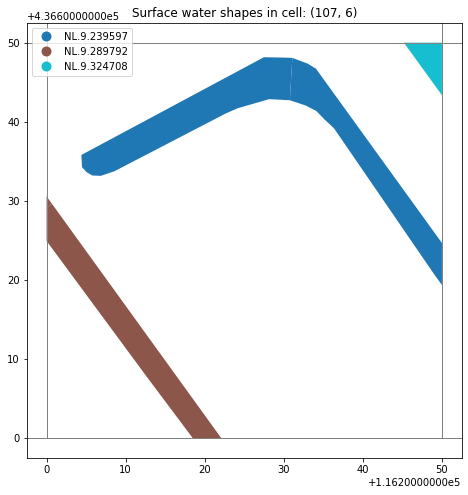

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sfw_grid.loc[mask].plot(column="unique_id", legend=True, ax=ax,
                        legend_kwds={"loc": "upper left"})
xlim = ax.get_xlim()
ylim = ax.get_ylim()
gwf.modelgrid.plot(ax=ax)
ax.set_xlim(xlim[0], xlim[0]+model_ds.delr*1.1)
ax.set_ylim(ylim)
ax.set_title(f"Surface water shapes in cell: {cid}");

Now we want to aggregate the features in each cell to obtain a representative set of parameters (`stage`, `conductance`, `bottom elevation`) to use in the model. There are several aggregation methods. Note that the names of the methods are not representative of the aggregation applied to each parameter. For a full description see the following list:

- `'area_weighted'`
  - **stage**: area-weighted average of stage in cell
  - **cond**: conductance is equal to area of surface water divided by bottom resistance
  - **elev**: the lowest bottom elevation is representative for the cell
- `'max_area'`
  - **stage**: stage is determined by the largest surface water feature in a cell
  - **cond**: conductance is equal to area of all surface water features divided by bottom resistance
  - **elev**: the lowest bottom elevation is representative for the cell
- `'de_lange'`
  - **stage**: area-weighted average of stage in cell
  - **cond**: conductance is calculated using the formulas derived by De Lange (1999).
  - **elev**: the lowest bottom elevation is representative for the cell
  
Let's try using `area_weighted`. This means the stage is the area-weighted average of all the surface water features in a cell. The conductance is calculated by dividing the total area of surface water in a cell by the bottom resistance (`c0`). The representative bottom elevation is the lowest elevation present in the cell.

In [14]:
try:
    nlmod.mfpackages.surface_water.aggregate_surface_water(
        sfw_grid, "area_weighted")
except ValueError as e:
    print(e)

Missing columns in DataFrame: {'c0'}


The function checks whether the requisite columns are defined in the DataFrame. We need to add a column containing the bottom resistance `c0`. Often a value of 1 day is used as an initial estimate.

In [15]:
sfw_grid["c0"] = 1.0  # days

Now aggregate the features.

In [16]:
celldata = nlmod.mfpackages.surface_water.aggregate_surface_water(
    sfw_grid, "area_weighted")

Aggregate surface water data: 100%|██████████| 9777/9777 [00:36<00:00, 269.61it/s]


Let's take a look at the result. We now have a DataFrame with cell-id as the index and the three parameters we need for each cell `stage`, `cond` and `rbot`. The area is also given, but is not needed for the groundwater model. 

In [17]:
celldata.head(10)

stage        cond  rbot        area
0 0  -1.85  564.080671 -2.15  564.080671
  1  -1.85  313.860486 -2.15  313.860486
  2  -1.85  119.934212 -2.15  119.934212
  3  -1.85  523.168252 -2.85  523.168252
  4  -1.85  252.657548 -2.15  252.657548
  5  -1.85  184.101176 -2.15  184.101176
  6  -1.85  203.224646 -2.15  203.224646
  7  -1.85  289.174129 -2.15  289.174129
  8  -1.85  229.423507 -2.15  229.423507
  9  -1.85  347.101131 -2.15  347.101131

### [Build stress period data](#top)<a id='3.3'></a>

The next step is to take our cell-data and build convert it to 'stress period data' for MODFLOW. This is a data format that defines the parameters in each cell in the following format:

```
[[(cellid1), param1a, param1b, param1c],
 [(cellid2), param2a, param2b, param2c],
 ...]
```

The required parameters are defined by the MODFLOW-package used:

- **RIV**: for the river package `(stage, cond, rbot)`
- **DRN**: for the drain package `(stage, cond)`
- **GHB**: for the general-head-boundary package `(stage, cond)`

We're selecting the RIV package:

In [18]:
riv_spd = nlmod.mfpackages.surface_water.build_spd(celldata, "RIV", model_ds)

Building stress period data RIV:: 100%|██████████| 9777/9777 [00:26<00:00, 365.05it/s] 

Skipped 1024 cells because of missing/erroneous data!


Take a look at the stress period data for the river package:

In [19]:
riv_spd[:10]

[[(0, 0, 0), -1.8499999999999996, 564.0806709062632, -2.15],
 [(0, 0, 1), -1.85, 313.8604857183299, -2.15],
 [(0, 0, 2), -1.85, 119.93421157955878, -2.15],
 [(0, 0, 3), -1.8499999999999999, 523.1682520160886, -2.85],
 [(0, 0, 4), -1.85, 252.6575481379218, -2.15],
 [(0, 0, 5), -1.85, 184.10117604224467, -2.15],
 [(0, 0, 6), -1.85, 203.22464616401703, -2.15],
 [(0, 0, 7), -1.85, 289.1741290302004, -2.15],
 [(0, 0, 8), -1.85, 229.42350669459668, -2.15],
 [(0, 0, 9), -1.85, 347.1011307303384, -2.15]]

### [Create RIV package](#top)<a id='3.4'></a>

The final step is to create the river package using flopy.

In [20]:
riv = flopy.mf6.ModflowGwfriv(gwf, stress_period_data=riv_spd)

Plot the river boundary condition to see where rivers were added in the model

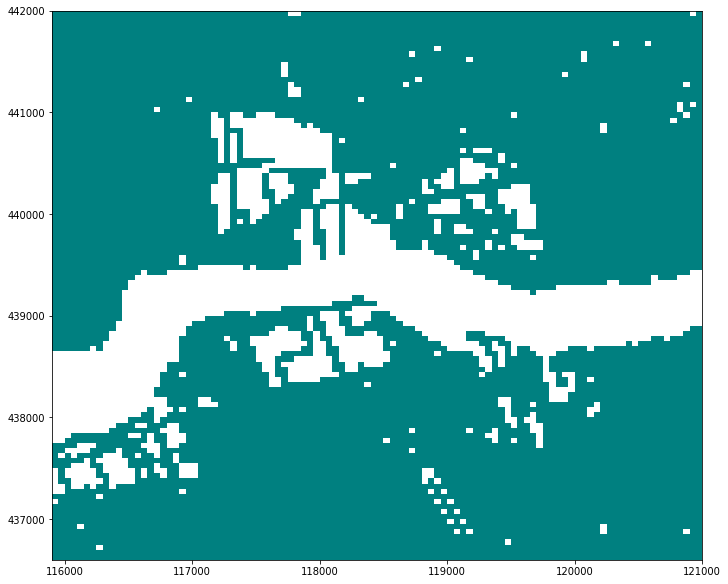

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8), constrained_layout=True)
mv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0)
mv.plot_bc("RIV");

## [Write + run model](#top)<a id='4'></a>

Now write the model simulation to disk, and run the simulation.

In [22]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model model3...
    writing model name file...
    writing package dis...
    writing package npf...
    writing package ic...
    writing package oc...
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 8753 based on size of stress_period_data


In [23]:
sim.run_simulation()

FloPy is using the following  executable to run the model: /home/david/Github/nlmod/nlmod/mfpackages/../../bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.1 02/18/2021

   MODFLOW 6 compiled Feb 18 2021 20:22:48 with IFORT compiler (ver. 19.10.3)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also 

(True, [])

## [Visualize results](#top)<a id='5'></a>

To see whether our surface water was correctly added to the model, let's visualize the results. We'll load the calculated heads, and plot them.

In [24]:
hds_obj = flopy.utils.HeadFile(os.path.join(
    model_ds.model_ws, model_ds.model_name) + ".hds")

Load the data, and set NODATA (often values of +1e30) to `np.nan`.

In [25]:
h = hds_obj.get_alldata()
h[h > 1e20] = np.nan  # set NODATA to NaN

Plot the heads in a specific model layer

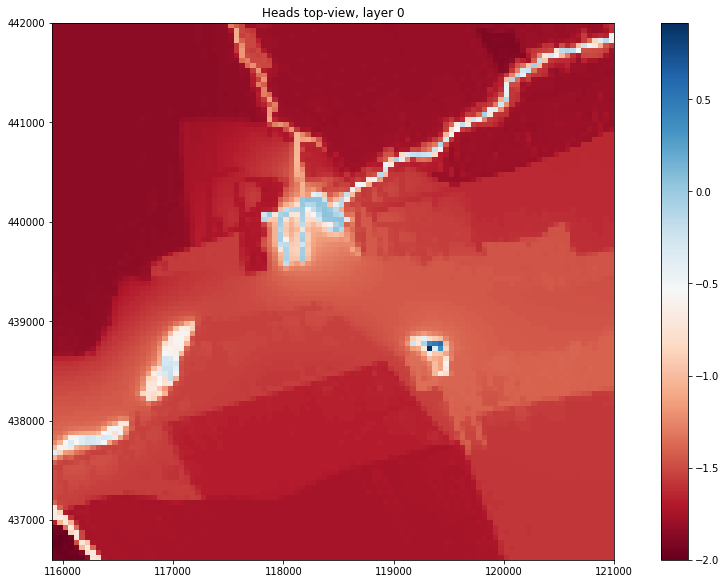

In [26]:
ilay = 0
fig, ax = plt.subplots(1, 1, figsize=(10, 8), constrained_layout=True)
mv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=ilay)
qm = mv.plot_array(h[-1], cmap="RdBu")  # last timestep
mv.plot_ibound()  # plot inactive cells in red
fig.colorbar(qm, shrink=1.0)
ax.set_title(f"Heads top-view, layer {ilay}");

In cross-section

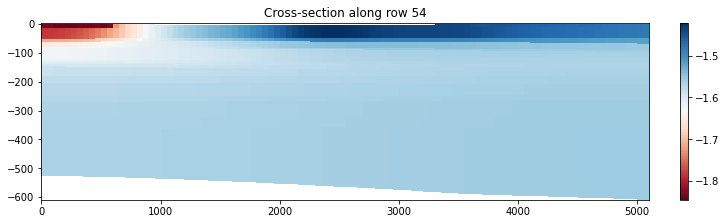

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3), constrained_layout=True)
xs = flopy.plot.PlotCrossSection(
    model=gwf, ax=ax, line={"row": gwf.modelgrid.nrow // 2})
qm = xs.plot_array(h[-1], cmap="RdBu")  # last timestep
xs.plot_ibound()  # plot inactive cells in red
fig.colorbar(qm, shrink=1.0)
ax.set_title(f"Cross-section along row {gwf.modelgrid.nrow // 2}");